<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A1%D0%B8%D0%B0%D0%BC%D1%81%D0%BA%D0%B8%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D1%81_Keras%2C_TensorFlow_%D0%B8_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;"><b>Сиамские сети с Keras, TensorFlow и Deep Learning</b></h1>

<h1 style = "text-align: center;"> <b> Siamese networks with Keras, TensorFlow and Deep Learning </b> </h1>

В этом уроке мы реализуем и обучим сиамские сети с помощью Keras, TensorFlow и Deep Learning.

In this tutorial, we will implement and train Siamese networks using Keras, TensorFlow, and Deep Learning.

Затем мы рассмотрим структуру каталогов нашего проекта и реализуем файл конфигурации, за которым следуют три вспомогательные функции:

We will then look at the directory structure of our project and implement a configuration file followed by three helper functions:

1.   Метод, используемый для генерации пар изображений, чтобы мы могли обучать нашу сиамскую сеть. The method used to generate pairs of images so that we can train our Siamese network. 
2. Пользовательский слой CNN для вычисления евклидовых расстояний между векторами внутри сети. Custom CNN layer for calculating Euclidean distances between vectors within the network.
3.   Утилита, используемая для записи истории обучения сиамской сети на диск. A utility used to write the learning history of the Siamese network to disk.


Используя вспомогательные функции, мы выполним обучение сиамской сети на наборе данных MNIST.

We will train the Siamese network on the MNIST dataset with helper functions.

### Установите необходимые библиотеки

### Install the necessary packages

In [2]:
!pip install tensorflow==2.3.0

### Загрузите zip-файл с кодом

### Download the code zip file

In [3]:
!wget http://dataudt.ru/datasets/cv/Lesson_2.Siamese_networks_with_Keras_TensorFlow_and_Deep_Learning.zip
!unzip -qq Lesson_2.Siamese_networks_with_Keras_TensorFlow_and_Deep_Learning.zip

--2022-02-21 08:55:26--  http://dataudt.ru/datasets/cv/Lesson_2.Siamese_networks_with_Keras_TensorFlow_and_Deep_Learning.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291702 (285K) [application/zip]
Saving to: ‘Lesson_2.Siamese_networks_with_Keras_TensorFlow_and_Deep_Learning.zip’

Lesson_2.Siamese_ne 100%[===================>] 284.87K   250KB/s    in 1.1s    

2022-02-21 08:55:28 (250 KB/s) - ‘Lesson_2.Siamese_networks_with_Keras_TensorFlow_and_Deep_Learning.zip’ saved [291702/291702]



### Импорт пакетов

### Import Packages

In [4]:
# импортируем необходимые библиотеки
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os

### Определите наш класс `Config`

### Define our `Config` class

In [5]:
class Config:
    # указываем входные параметры для нашей нейросети
    # specify the shape of the inputs for our network
    IMG_SHAPE = (28, 28, 1)
    
    
    # указываем размер батча и количество эпох
    # specify the batch size and number of epochs
    BATCH_SIZE = 64
    EPOCHS = 100

    # определяем путь к базовой выходной папке
    # define the path to the base output directory
    BASE_OUTPUT = "output"

    # используем базовый путь для вывода модели
    # use the base output path to derive the path to the serialized
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
    # модель вместе с историей обучения
    
    # model along with training history plot
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# создаем экземпляр класса конфигурации
# instantiate the config class
config = Config()

### Реализация наших функций создания пар, евклидова расстояния и истории построения графиков.

### Implementing our pair generation, euclidean distance, and plot history utility functions

In [6]:
def make_pairs(images, labels):
	# создаем два пустых списка  	
    # для хранения пар изображений
    # initialize two empty lists to hold the (image, image) pairs and
	pair_images = []
    # для классов, показывающих является ли пара положительной или отрицательной   
	# labels to indicate if a pair is positive or negative
	pair_labels = []

    # вычисляем общее количество классов, представленных в датасете 
    # calculate the total number of classes present in the dataset
	num_classes = len(np.unique(labels))
    # создаем список индексов для каждой метки класса,
    # в котором есть индексы для каждого примера с заданной меткой
    # and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	idx = [np.where(labels == i)[0] for i in range(0, num_classes)]

    # проходим циклом через все изображения 
    # loop over all images
	for idxA in range(len(images)):

		# выбираем изображение и метку, принадлежащих текущей итерации  
        # grab the current image and label belonging to the current
		# iteration
		current_image = images[idxA]
		label = labels[idxA]
    
        
		# случайно выбираем изображение, которое принадлежит *тому же* классу
        # randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		pos_image = images[idxB]
           
		# подготавливаем позитивную пару и обновляем изображения и индексы
        # prepare a positive pair and update the images and labels
		# lists, respectively 
		pair_images.append([current_image, pos_image])
		pair_labels.append([1])
    
        # получаем индексы для каждой из меток классов *не* равных текущей метке
        # случайным образом выбираем изображение с меткой, *не* равной текущей метке
        # grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		neg_image = images[np.random.choice(negIdx)]

		# подготавливаем негативную пару и обновляем списки 
        # prepare a negative pair of images and update our lists
		pair_images.append([current_image, neg_image])
		pair_labels.append([0])
  
	# возвращаем кортеж, состоящий из пары изображений и их меток 
    # return a 2-tuple of our image pairs and labels
	return (np.array(pair_images), np.array(pair_labels))

In [7]:
def euclidean_distance(vectors):
    # распределяем векторы в отдельные списки
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

    # вычисляем сумму квадратов расстояний между векторами
    # compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

    # возвращаем евклидово расстояние между векторами
    # return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [8]:
def plot_training(H, plotPath):
    # строим графики, отображающие историю обучения
    # construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

### Реализация сиамской сетевой архитектуры с помощью Keras и TensorFlow

### Implementing the siamese network architecture with Keras and TensorFlow

In [9]:
def build_siamese_model(inputShape, embeddingDim=48):
    # указываем входы для признаков сети
    # specify the inputs for the feature extractor network
	inputs = Input(inputShape)

    # определяем первый набор слоев: CONV => RELU => POOL => DROPOUT 
    # define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)

    # второй набор: CONV => RELU => POOL => DROPOUT layers
    # second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)

    # подготавливаем выходы
    # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)

    # создаем модель
    # build the model
	model = Model(inputs, outputs)

    # возвращаем модель вызванной функции
    # return the model to the calling function
	return model

### Обучение нашей сиамской сети с помощью Keras и TensorFlow

### Training our siamese network with Keras and TensorFlow

In [10]:

# загружаем MNIST датасет и нормируем значения пикселей в диапазоне от 0 до 1 
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# добавляем размерность канала к изображениям
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# подготавливаем позитивную и негативную пары изображений 
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step
[INFO] preparing positive and negative pairs...


In [11]:

# выбираем конфигурацию для сиамской сети
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(shape=config.IMG_SHAPE)
featureExtractor = build_siamese_model(config.IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)


# собираем получившуюся сеть
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

[INFO] building siamese network...


In [12]:

# компилируем модель
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

# train the model
# обучаем модель
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=config.BATCH_SIZE, 
	epochs=config.EPOCHS)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.6279 - accuracy: 0.6343 - val_loss: 0.5890 - val_accuracy: 0.6916
Epoch 2/100
1875/1875 [==============================] - 25s 13ms/step - loss: 0.5784 - accuracy: 0.6974 - val_loss: 0.5262 - val_accuracy: 0.7491
Epoch 3/100
1875/1875 [==============================] - 25s 13ms/step - loss: 0.5404 - accuracy: 0.7294 - val_loss: 0.4831 - val_accuracy: 0.7778
Epoch 4/100
1875/1875 [==============================] - 25s 13ms/step - loss: 0.5084 - accuracy: 0.7525 - val_loss: 0.4527 - val_accuracy: 0.7988
Epoch 5/100
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4849 - accuracy: 0.7684 - val_loss: 0.4336 - val_accuracy: 0.8065
Epoch 6/100
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4682 - accuracy: 0.7778 - val_loss: 0.4230 - val_accuracy: 0.8108
Epoch 7/100
1875/1875 [==============================] - 25s 13ms/s

[INFO] saving siamese model...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: output/siamese_model/assets
[INFO] plotting training history...


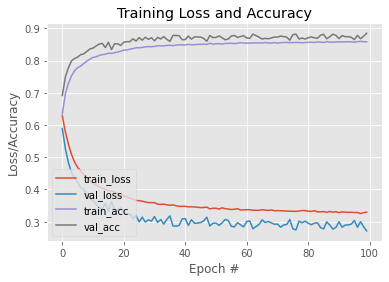

In [13]:

# сохраняем модель на диск
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(config.MODEL_PATH)


# выводим историю обучения
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, config.PLOT_PATH)